In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Data import

In [39]:
col_names = ["Date","Time","Tag Comment","Motor Vol Flow","Motor Flow In","Motor Flow Out","Motor Surf top","Motor Surf Side","Temp Pt100 RTD winding U", \
            "Temp Pt100 RTD winding V", "Temp Pt100 RTD winding W", "Temp PTC thermistor winding", "Temp Feed-through plate", \
            "Lead intersection", "Temp Cable gland", "Temp Terminal box seal", "Temp Terminal", "Temp Ambient", "Frequency", "Voltage", \
            "Current", "Power factor", "Input power", "Output power", "Torque", "Speed", "Slip"]
df = pd.read_excel('./HDE-INT-MOT-20221028-01_HT8_03_N85z-4_OC2_50Hz_70C_R_000759_221107_100743.GEV.xlsx',header=32)
df.columns = col_names
df = df.drop([0],axis=0)
df = df.drop(["Tag Comment","Date","Temp PTC thermistor winding"],axis=1)
df["Time"] = list(np.arange(19206))
df = df[df["Frequency"]!="INVALID"]
print(df.shape)
df.head(5)

/Users/danilfedorovsky/miniforge3/envs/ML/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(19204, 24)


,Time,Motor Vol Flow,Motor Flow In,Motor Flow Out,Motor Surf top,Motor Surf Side,Temp Pt100 RTD winding U,Temp Pt100 RTD winding V,Temp Pt100 RTD winding W,Temp Feed-through plate,...,Temp Ambient,Frequency,Voltage,Current,Power factor,Input power,Output power,Torque,Speed,Slip
1,0,49.6,41.2,39.3,29.2,29.0,30.9,30.8,30.7,19.9,...,20.4,50.0,400.4,100.86,0.35,42.43,26.78,170.98,1495.5,0.3
2,1,49.7,41.2,39.3,29.1,29.2,30.9,30.8,30.8,19.8,...,20.4,50.0,400.4,100.87,0.35,42.41,26.78,171.02,1495.6,0.28
3,2,49.9,41.2,39.3,29.0,29.0,30.9,30.8,30.8,19.9,...,20.4,50.0,400.4,100.96,0.35,42.48,26.81,171.21,1495.5,0.29
4,3,49.8,41.2,39.3,29.2,29.1,31.0,30.9,30.8,19.9,...,20.4,50.0,400.4,100.88,0.35,42.45,26.81,171.17,1495.5,0.3
5,4,49.7,41.2,39.3,29.3,29.0,31.0,30.9,30.9,20.2,...,20.4,50.0,400.3,107.1,0.449,57.71,35.88,229.55,1492.6,0.52


# Scatterplot Analysis

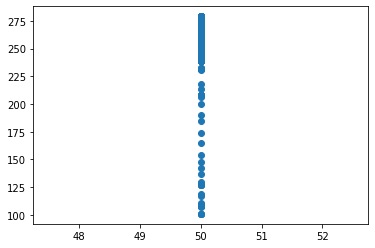

In [42]:
plt.scatter(df["Frequency"],df["Current"])

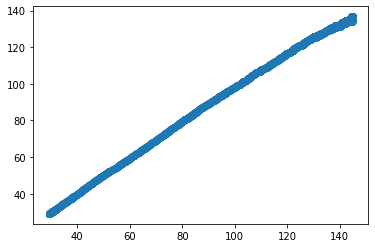

In [4]:
plt.scatter(df["Motor Surf top"],df["Motor Surf Side"])

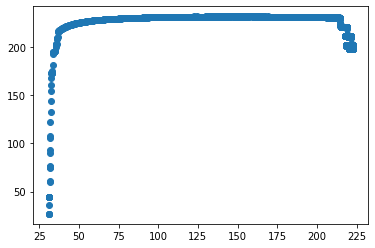

In [91]:
plt.scatter(df["Temp Pt100 RTD winding U"],df["Output power"])

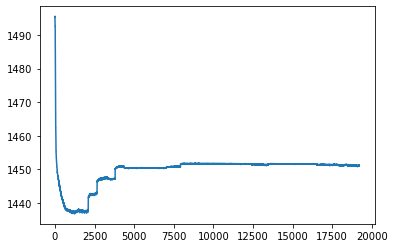

In [49]:
plt.plot(df["Speed"])

# Time for Data "Augmentation";)

In [97]:
print(max(df["Temp Pt100 RTD winding U"]))
print(max(df["Temp Pt100 RTD winding U"]))
print(max(df["Temp Pt100 RTD winding U"]))
print(max(df["Temp Pt100 RTD winding U"]))
print(max(df["Temp Terminal"]))# Temperatur and Anschlussklemme

222.7
222.7
222.7
222.7
85.1


# Case 1: Overheating

In [133]:
# Temp Terminal (an Anschlussklemme steigt über 90 => Gelb, über 100 => rot)
print(max(df["Temp Terminal"]))# Temperatur and Anschlussklemme

85.1


# Case 2: Increased Power Intake

# OMG it's Deep Learning

In [123]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchsummary import summary
from tqdm import tqdm

In [124]:
print(df.shape)
X = df.to_numpy(dtype=np.float16)
X = torch.Tensor(X)
print(X[1].shape)
Y = torch.stack([torch.zeros(19204),torch.zeros(19204),torch.ones(19204)]).view(19204,3)

(19204, 24)
torch.Size([24])


In [130]:
class DeepNeuralNetwork(nn.Module):
    """
    Binary Classifier detecting problems
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(DeepNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(24, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        """
        :param x: input data of this model
        :return: output data of this model
        """
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.sm(x)
        return x

print(summary(DeepNeuralNetwork(),(1, 24)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 1024]             25,600
├─Linear: 1-2                            [-1, 1, 256]              262,400
├─Linear: 1-3                            [-1, 1, 64]               16,448
├─Linear: 1-4                            [-1, 1, 3]                195
├─Softmax: 1-5                           [-1, 1, 3]                --
Total params: 304,643
Trainable params: 304,643
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.16
Estimated Total Size (MB): 1.17
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 1024]             25,600
├─Linear: 1-2                            [-1, 1, 256]              262,400
├─Linear: 1-3                            [-1, 1, 64]               16,448
├─Linear: 1-4                            [-1, 1, 3

In [132]:
EPOCHS = 5
INIT_LR = 0.01
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = DeepNeuralNetwork().to(device)
model= torch.nn.DataParallel(model,device_ids=[0])

lossBCE = CrossEntropyLoss()

opt = Adam(model.parameters(), lr=INIT_LR)

H = {"train_loss":[]}

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(X))): # Iterate over Training Examples
        x = X[i].unsqueeze(0)
        y = Y[i].unsqueeze(0)
        x_pred=model(x)
        loss = lossBCE(x_pred,y)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        H["train_loss"].append(float(loss))
    print("Training Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["train_loss"])/(len(X)*(epoch+1))))
       
PATH = "./modelfinal"
torch.save(model.state_dict(), PATH + ".pt")
print(totalTrainLoss)

Epoch: 1/5


100%|██████████| 19204/19204 [00:23<00:00, 823.71it/s]


Total Training Loss in Epoch 1 : 1.21807672057927
Epoch: 2/5


100%|██████████| 19204/19204 [00:21<00:00, 913.26it/s]


Total Training Loss in Epoch 2 : 1.21807672057927
Epoch: 3/5


100%|██████████| 19204/19204 [00:21<00:00, 905.86it/s]


Total Training Loss in Epoch 3 : 1.2180767205792697
Epoch: 4/5


100%|██████████| 19204/19204 [00:21<00:00, 879.93it/s]


Total Training Loss in Epoch 4 : 1.2180767205792702
Epoch: 5/5


100%|██████████| 19204/19204 [00:20<00:00, 922.51it/s]


Total Training Loss in Epoch 5 : 1.21807672057927
0
